# Advanced dimensionality reduction techniques

## Dimensionality reduction on images

In [1]:
from time import time
import numpy as np
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, preprocessing)
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

### Loading and inspecting the data

In [2]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape

print("Total number of samples: ", n_samples)
print("Features per sample: ", n_features)

Total number of samples:  1083
Features per sample:  64


In [3]:
X[0,:]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [4]:
# What digit is this?
y[0]

0

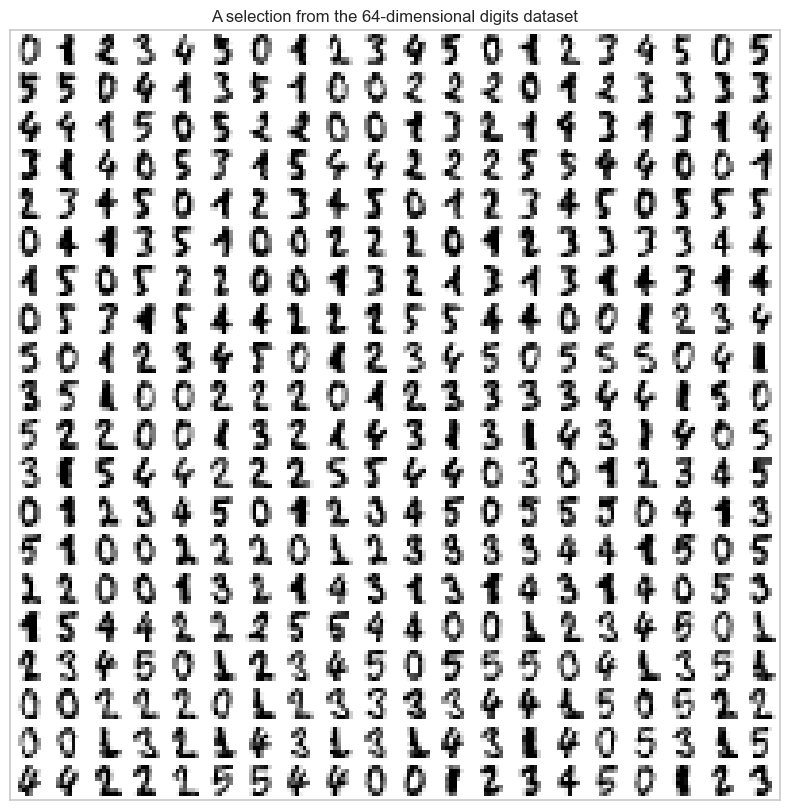

In [5]:
# Plot images of the digits
n_img_per_row = 20

# create a large grid of zeros
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))

# for each column
for i in range(n_img_per_row):
    
    # find the x-coordinate
    ix = 10 * i + 1
    
    # for each row 
    for j in range(n_img_per_row):
        
        # find the y-coordinate
        iy = 10 * j + 1
        
        # change the pixels in this part of the grid to match the digit
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

# plot the grid as a single image
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')
plt.show()

### Dimensionality reduction techniques

In [6]:
# Scale and visualise the embedding vectors
def plot_embedding(X, title=None):
    
    # normalise data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    
    ax = plt.subplot(111)
    
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

### Principal component analysis (PCA)

In [7]:
print("Computing PCA projection")
t0 = time()
X_pca = decomposition.PCA(n_components=2).fit_transform(X)
t1 = time()
print("Finished PCA projection in " + str(t1-t0) + "s.")

Computing PCA projection
Finished PCA projection in 0.014838218688964844s.


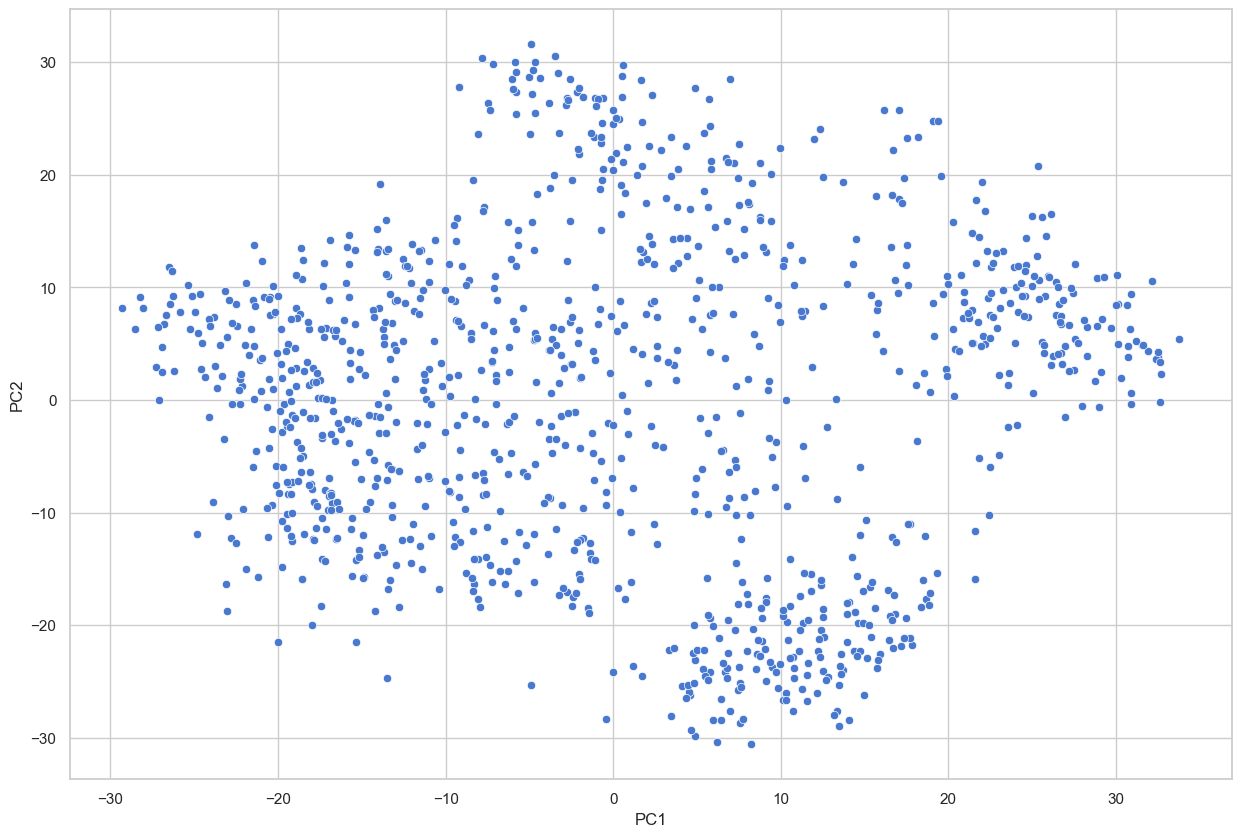

In [8]:
ax = sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                     sizes=(10, 200))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

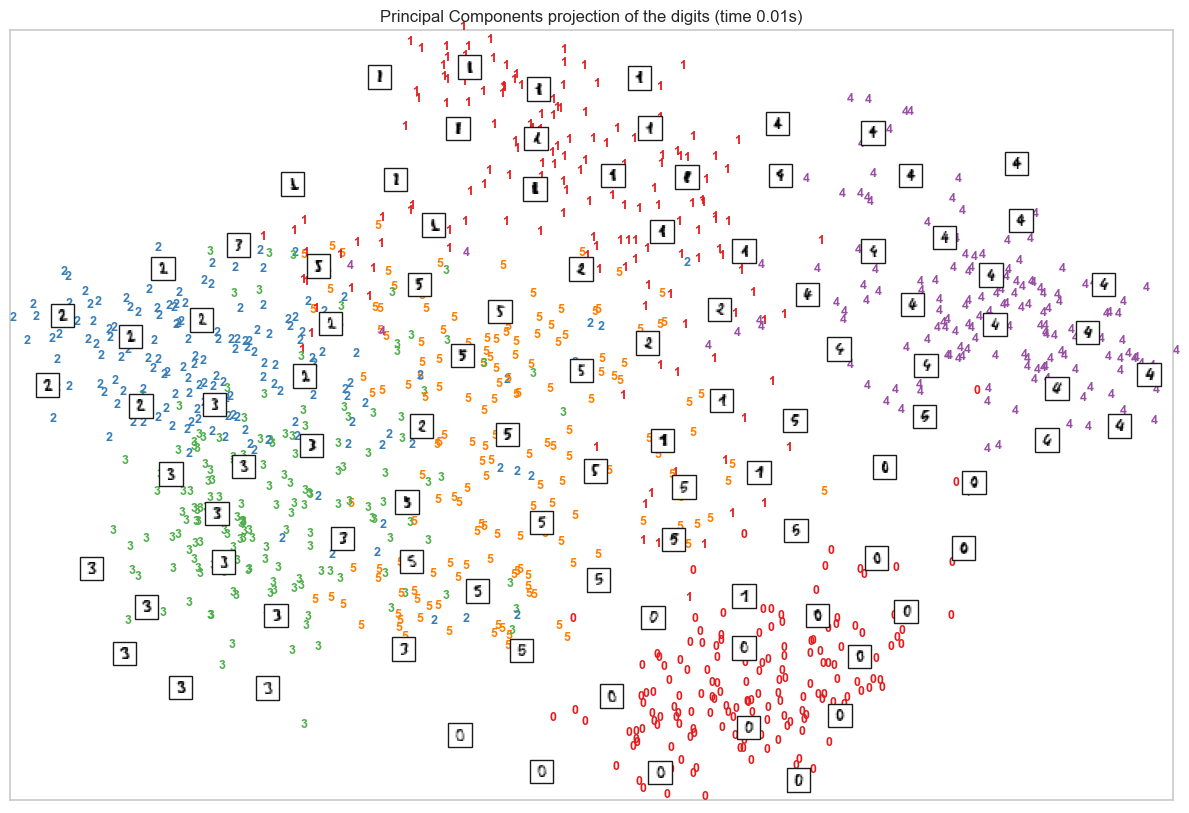

In [9]:
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (t1 - t0))
plt.show()

### Multi-dimensional scaling (MDS)

In [10]:
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, 
                   n_init=4, 
                   max_iter=200,
                   n_jobs=-1,
                   random_state=42,
                   dissimilarity='euclidean')
t0 = time()
X_mds = clf.fit_transform(X)
t1 = time()
print("Done. Stress: %f" % clf.stress_)

Computing MDS embedding


C:\Users\Geoffrey\AppData\Local\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Done. Stress: 134251964.793076


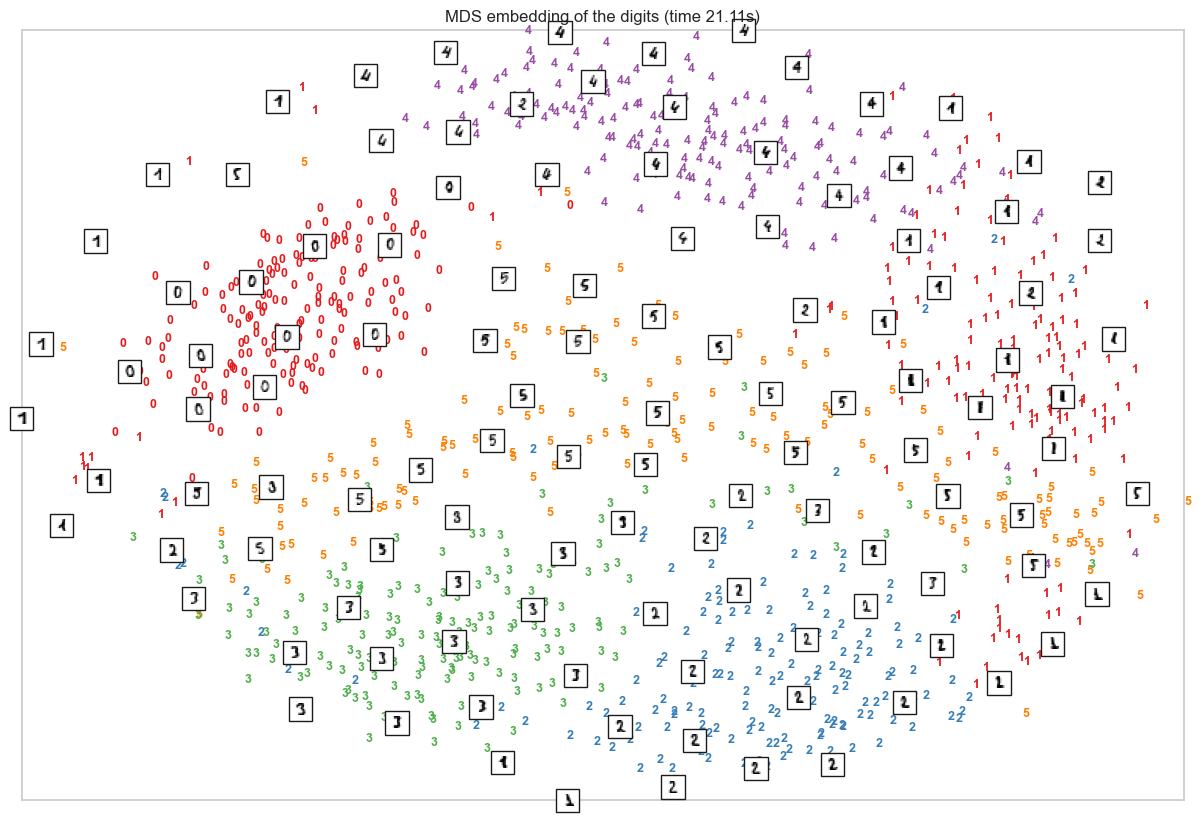

In [11]:
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (t1 - t0))

### t-distributed stochastic neighbor embedding (t-SNE)

In [13]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2,
                     perplexity=40,
                     metric='euclidean',
                     init='pca',
                     verbose=1,
                     random_state=42)
t0 = time()
X_tsne = tsne.fit_transform(X)
t1 = time()

Computing t-SNE embedding
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1083 samples in 0.001s...
[t-SNE] Computed neighbors for 1083 samples in 0.598s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1083
[t-SNE] Computed conditional probabilities for sample 1083 / 1083
[t-SNE] Mean sigma: 12.679072
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.636963
[t-SNE] KL divergence after 1000 iterations: 0.538814


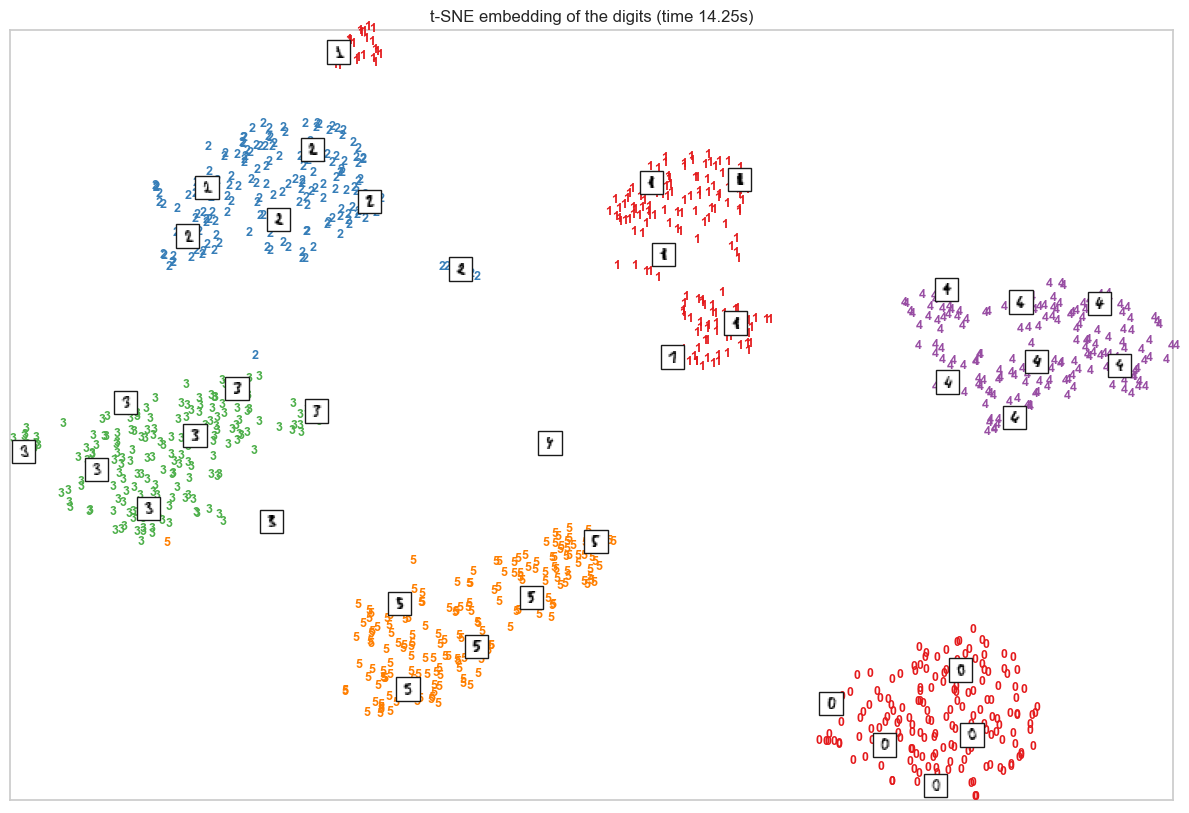

In [14]:
plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (t1 - t0))

plt.show()

## Dimensionality reduction on text

In [15]:
import pandas as pd
import re

from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from collections import Counter

In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Data/unsupervised_sprint/capetownfreeway.csv', encoding='ISO-8859-1')
df.head()

,favorite_count,source,text,in_reply_to_screen_name,is_retweet,created_at,retweet_count,id_str
0,0,Twitter Web Client,Update: Stationary Vehicle: N7 northbound befo...,NaN,False,Wed Jan 11 14:37:46 +0000 2017,1,819191575490297856
1,0,Twitter Web Client,"Crash: N2 outbound after Raapenberg, right lan...",NaN,False,Thu Jan 26 13:54:41 +0000 2017,1,824616552515395586
2,0,Twitter Web Client,Update: Congestion N2 Inbound at M3 Southbound...,NaN,False,Fri Jan 27 13:15:22 +0000 2017,0,824969046705725445
3,0,Twitter Web Client,Update: Stationary vehicle: N1 Outbound at Pla...,NaN,False,Wed Jan 25 12:36:11 +0000 2017,0,824234408358068225
4,0,Twitter Web Client,"Veldfire: N2 Inbound before Raapenberg, Left L...",NaN,False,Mon Jan 16 03:12:10 +0000 2017,1,820830979468181504


In [17]:
df.drop(['source', 'in_reply_to_screen_name', 'is_retweet'],
        axis=1, inplace=True)

In [18]:
def clean_tweet(tweet):
    no_link_loc = re.sub(r"http\S+", "", tweet)
    no_num_loc = no_link_loc.lower()
    for c in ['inbound','outbound','after','before','update','after','animals','roadworks',':',',',
              '#','@','savewater', 'boozefreeroads','speedkillsfacts','saferoadsforall', 'sharetheroad',
              'alwaysbuckleup', 'boozefreeroad','alwaysbuckleup','savekidslives','.','walksafe']:
        no_num_loc = no_num_loc.replace(c, '')
        
    no_num_loc = no_num_loc.split(',')[0]
    try:
        return no_num_loc
    except:
        pass

In [19]:
df['clean_tweet'] = df['text'].apply(clean_tweet)
df.head()

,favorite_count,text,created_at,retweet_count,id_str,clean_tweet
0,0,Update: Stationary Vehicle: N7 northbound befo...,Wed Jan 11 14:37:46 +0000 2017,1,819191575490297856,stationary vehicle n7 northbound bosmansdam ...
1,0,"Crash: N2 outbound after Raapenberg, right lan...",Thu Jan 26 13:54:41 +0000 2017,1,824616552515395586,crash n2 raapenberg right lane closed expect...
2,0,Update: Congestion N2 Inbound at M3 Southbound...,Fri Jan 27 13:15:22 +0000 2017,0,824969046705725445,congestion n2 at m3 southbound ramp is clear...
3,0,Update: Stationary vehicle: N1 Outbound at Pla...,Wed Jan 25 12:36:11 +0000 2017,0,824234408358068225,stationary vehicle n1 at plattekloof left la...
4,0,"Veldfire: N2 Inbound before Raapenberg, Left L...",Mon Jan 16 03:12:10 +0000 2017,1,820830979468181504,veldfire n2 raapenberg left lane closed driv...


In [20]:
import nltk
# nltk.download('punkt')

(-0.5, 799.5, 399.5, -0.5)

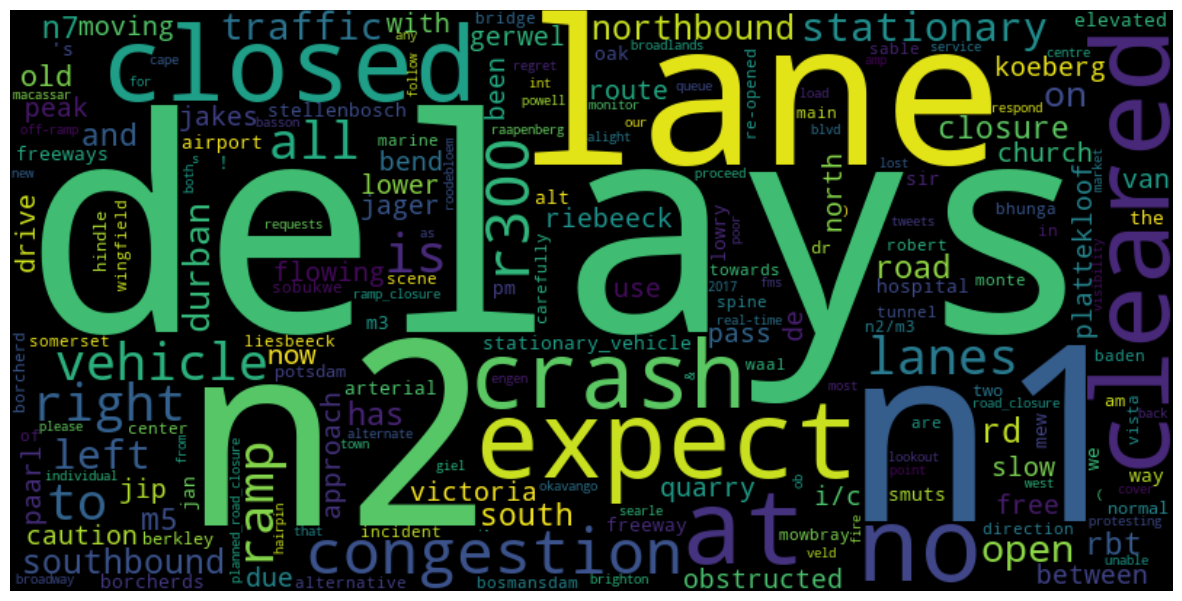

In [21]:
words = []
for i in df.clean_tweet:
    words.extend(word_tokenize(i))
    
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(frequencies = Counter(words))
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

### Term frequency–inverse document frequency (tf–idf)

In [22]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=50, stop_words='english')
X = vectorizer.fit_transform(df.clean_tweet).toarray()

The tf–idf vectorizer creates a feature set of length 50, with the most frequently used words in the tweets we provided. It takes care of English stopwords such as "in", "on", "the", etc. which carry little to no meaning in terms of the content of the tweet and helps us to remove a large amount of noise.

In [23]:
vocab = vectorizer.get_feature_names_out()
print(vocab)

['church' 'cleared' 'closed' 'closure' 'congestion' 'crash' 'delays'
 'drive' 'durban' 'expect' 'flowing' 'free' 'jip' 'koeberg' 'lane' 'lanes'
 'left' 'lower' 'm3' 'm5' 'moving' 'n1' 'n2' 'n7' 'north' 'northbound'
 'obstructed' 'old' 'open' 'paarl' 'peak' 'plattekloof' 'quarry' 'r300'
 'ramp' 'rbt' 'rd' 'riebeeck' 'right' 'road' 'route' 'slow' 'south'
 'southbound' 'stationary' 'traffic' 'use' 'van' 'vehicle' 'victoria']


In [24]:
X = pd.DataFrame(X, columns=vocab)
print("n_samples: %d, n_features: %d" % X.shape)

n_samples: 24158, n_features: 50


### Principal component analysis (PCA)

In [25]:
scaler = preprocessing.StandardScaler()
pca = decomposition.PCA(n_components=2)

print("Computing PCA projection")
t0 = time()
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X_scaled)
t1 = time()
print("Finished PCA projection in " + str(t1-t0) + "s.")

Computing PCA projection
Finished PCA projection in 0.23677921295166016s.


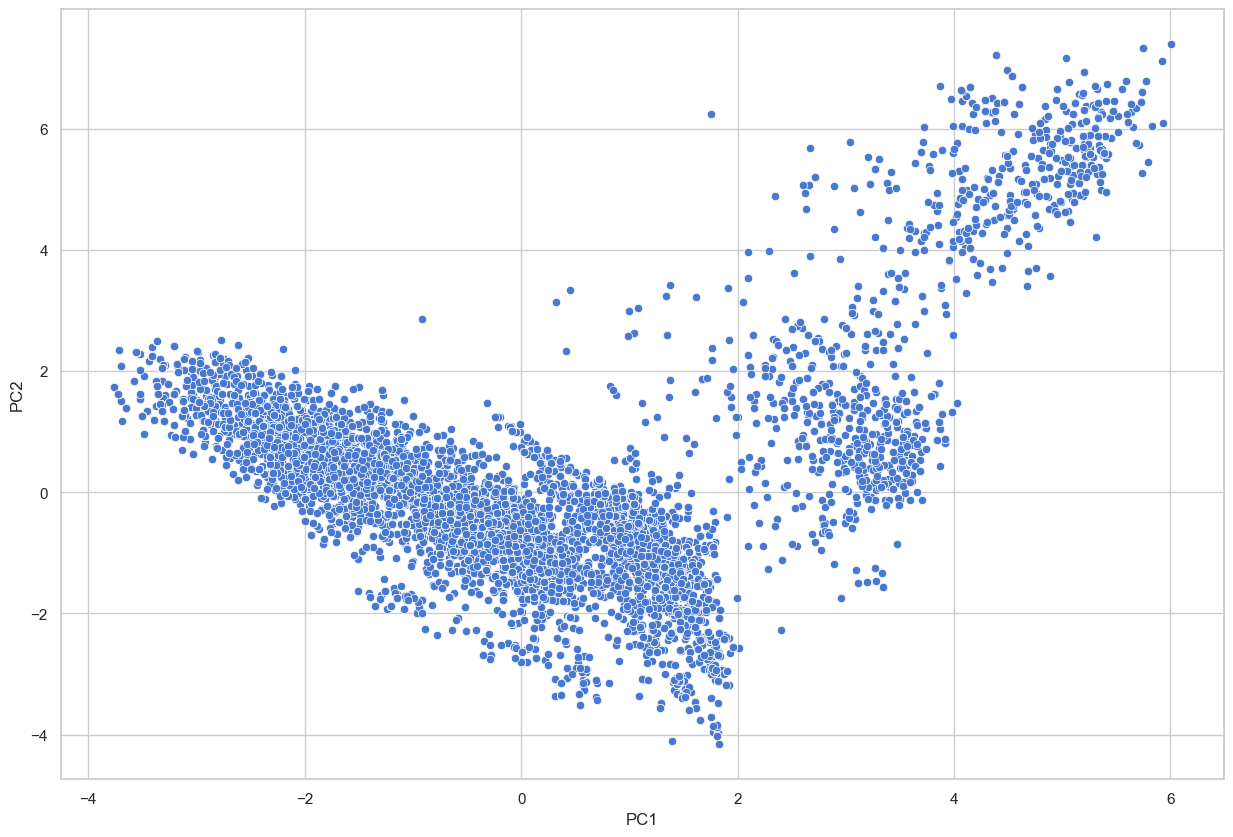

The first two principal components explain 15.0 % of the variance in the data


In [26]:
ax = sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])

plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()
print("The first two principal components explain " + 
      str(np.round(sum(pca.explained_variance_ratio_[:2]),2)*100) + " % of the variance in the data")

Let's make it possible for us to view what text each data point portrays.

In [27]:
import cufflinks as cf
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [28]:
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['text'] = df['clean_tweet']

In [29]:
data = [
    go.Scatter(
        x = pca_df.iloc[:2000,0].values,
        y = pca_df.iloc[:2000,1].values,
        text = pca_df.iloc[:2000,2].values,
        hoverinfo = 'text',
        marker = dict(
            color = 'lightblue'
        ),
        mode='markers',
        showlegend = False
    )
]

iplot(data, filename = "add-hover-text")

Hover over the data points to view the text that data point represents.

### Multi-dimensional scaling (MDS)

In [30]:
from sklearn.manifold import MDS
print("Computing MDS embedding")
mds = manifold.MDS(n_components=2, 
                   n_init=2, 
                   max_iter=200,
                   n_jobs=-1,
                   random_state=42,
                   dissimilarity='euclidean')
t0 = time()
X_mds = mds.fit_transform(X.iloc[:2000,:])
t1 = time()
print("Done. Stress: %f" % mds.stress_)

Computing MDS embedding


C:\Users\Geoffrey\AppData\Local\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



Done. Stress: 454048.166485


In [31]:
mds_df = pd.DataFrame(X_mds, columns=['D1', 'D2'])
mds_df['text'] = df['clean_tweet']

In [32]:
data = [
    go.Scatter(
        x = mds_df.iloc[:2000,0].values,
        y = mds_df.iloc[:2000,1].values,
        text = mds_df.iloc[:2000,2].values,
        hoverinfo = 'text',
        marker = dict(
            color = 'lightblue'
        ),
        mode='markers',
        showlegend = False
    )
]

iplot(data, filename = "add-hover-text")

### t-distributed stochastic neighbor embedding (t-SNE)

In [33]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2,
                     perplexity=40,
                     metric='euclidean',
                     init='pca',
                     verbose=1,
                     random_state=42)
t0 = time()
X_tsne = tsne.fit_transform(X.iloc[:5000,:])
t1 = time()

Computing t-SNE embedding
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.506s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.447769
[t-SNE] KL divergence after 1000 iterations: 0.420165


In [34]:
tsne_df = pd.DataFrame(X_tsne, columns=['D1', 'D2'])
tsne_df['text'] = df['clean_tweet']

In [35]:
data = [
    go.Scatter(
        x = tsne_df.iloc[:2000,0].values,
        y = tsne_df.iloc[:2000,1].values,
        text = tsne_df.iloc[:2000,2].values,
        hoverinfo = 'text',
        marker = dict(
            color = 'lightblue'
        ),
        mode='markers',
        showlegend = False
    )
]

iplot(data, filename = "add-hover-text")